# 1D case - Figure 12
Mono- and Bi-parameter 1D problem - Plot against the analytical solution

## Libraries import  

In [23]:

import sys  
import torch
import torch.nn as nn
from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
import neurom.src.Pre_processing as pre
from neurom.src.PDE_Library import Strain, Stress,VonMises_plain_strain,AnalyticSolution, AnalyticBiParametricSolution
from neurom.src.Training import Training_NeuROM_multi_level
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
from importlib import reload  
import tomllib
import numpy as np
import argparse


torch.manual_seed(0)

## Load the config file

In [24]:
    Configuration_file = 'Configurations/config_1D_ROM_12.toml'

    with open(Configuration_file, mode="rb") as file:
        config = tomllib.load(file)

## Definition of the space domain and mechanical proprieties of the structure

The initial material parameters, the geometry, mesh and the boundary conditions are set. 

In [25]:

# Material parameters definition

Mat = pre.Material(             flag_lame = True,                                   # If True should input lmbda and mu instead of E and nu
                                coef1     = config["material"]["E"],                # Young Modulus
                                coef2     = config["geometry"]["A"]                 # Section area of the 1D bar
                    )


# Create mesh object
MaxElemSize = pre.ElementSize(
                                dimension     = config["interpolation"]["dimension"],
                                L             = config["geometry"]["L"],
                                order         = config["interpolation"]["order"],
                                np            = config["interpolation"]["np"],
                                MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                            )
Excluded = []
Mesh_object = pre.Mesh( 
                                config["geometry"]["Name"],                         # Create the mesh object
                                MaxElemSize, 
                                config["interpolation"]["order"], 
                                config["interpolation"]["dimension"]
                        )

Mesh_object.AddBorders(config["Borders"]["Borders"])
Mesh_object.AddBCs(                                                                 # Include Boundary physical domains infos (BCs+volume)
                                config["geometry"]["Volume_element"],
                                Excluded,
                                config["DirichletDictionryList"]
                    )                   

Mesh_object.MeshGeo()                                                               # Mesh the .geo file if .msh does not exist
Mesh_object.ReadMesh()       
Mesh_object.AssemblyMatrix() 

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  3.1.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Dofs:           21


## Parametric study definition

The hypercube describing the parametric domain used for the tensor decomposition is set-up here

In [26]:
# ParameterHypercube = torch.tensor([ [   config["parameters"]["para_1_min"],
#                                         config["parameters"]["para_1_max"],
#                                         config["parameters"]["N_para_1"]],
#                                     [   config["parameters"]["para_2_min"],
#                                         config["parameters"]["para_2_max"],
#                                         config["parameters"]["N_para_2"]]])

ParameterHypercube = torch.tensor([ [   config["parameters"]["para_1_min"],
                                        config["parameters"]["para_1_max"],
                                        config["parameters"]["N_para_1"]]])

## Initialisation of the surrogate model

In [27]:
ROM_model = NeuROM(                                                                 # Build the surrogate (reduced-order) model
                    Mesh_object, 
                    ParameterHypercube, 
                    config,
                    config["solver"]["n_modes_ini"],
                    config["solver"]["n_modes_max"]
                    )

## Training the model

In [28]:
ROM_model.Freeze_Mesh()                                                             # Set space mesh coordinates as untrainable
ROM_model.Freeze_MeshPara()                                                         # Set parameters mesh coordinates as untrainable

ROM_model.TrainingParameters(   
                                loss_decrease_c = config["training"]["loss_decrease_c"], 
                                Max_epochs = config["training"]["n_epochs"], 
                                learning_rate = config["training"]["learning_rate"]
                            )

ROM_model.train()                                                                   # Put the model in training mode
if config["training"]["multiscl_max_refinment"] == 1:
    ROM_model = Training_NeuROM_multi_level(ROM_model,config, Mat)  
else:
    ROM_model, Mesh_object = Training_NeuROM_multi_level(ROM_model,config, Mat)  

* Refinement level: 0

**************** START TRAINING ***************



epoch 100 loss = -5.24711e-03 error = 1.8671e+02% modes = 1
epoch 200 loss = -2.45925e-02 error = 1.4370e+02% modes = 1
epoch 300 loss = -3.12343e-02 error = 6.2612e+01% modes = 1
epoch 400 loss = -3.23735e-02 error = 2.2112e+01% modes = 1
epoch 500 loss = -3.24927e-02 error = 1.19e+01% modes = 2
*************** END FIRST PHASE ***************

* Training time: 6.765199661254883s
* Saving time: 0.0s
* Evaluation time: 2.6941988468170166s
* Backward time: 2.041452646255493s
* Update time: 0.24602198600769043s
* Average epoch time: 0.01250499013170958s
************** START SECOND PAHSE *************

epoch 5 loss = -3.2504e-02 error = 1.0738e+01%
*************** END OF TRAINING ***************

* Training time: 7.512115478515625s

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Dofs:           40
* Refinement level: 1

**************** START TRAINING ***************

epoch 100 loss = -3.68859e-02 error 

## Plotting area

Reproducing figure 12

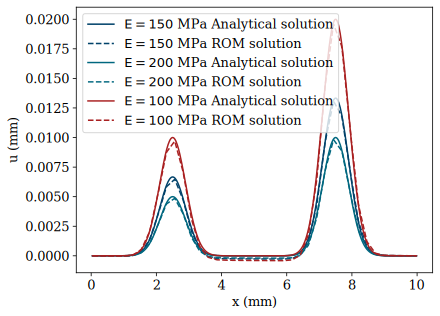

<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = "13"
import matplotlib.pyplot as plt
tikz = False
TrialCoordinates = torch.tensor([[i/50] for i in range(2,500)], 
            dtype=torch.float32, 
            requires_grad=True)


u0 = ROM_model.Space_modes[0].u_0
uL = ROM_model.Space_modes[0].u_L
name_model = 'Fig12'
PaperPara = torch.tensor([150])
PaperPara = PaperPara[:,None] # Add axis so that dimensions match
u_150 = ROM_model(TrialCoordinates,[PaperPara])
u_analytical_150 = AnalyticSolution(config["geometry"]["A"],PaperPara.item(),TrialCoordinates.data,u0,uL)
plt.plot(TrialCoordinates.data,u_analytical_150, color="#01426A", label = r'$E = 150~$MPa Analytical solution')
plt.plot(TrialCoordinates.data,u_150.data,'--', color="#01426A", label = r'$E = 150~$MPa ROM solution')

PaperPara = torch.tensor([200])
PaperPara = PaperPara[:,None] # Add axis so that dimensions match
u_200 = ROM_model(TrialCoordinates,[PaperPara])
u_analytical_200 = AnalyticSolution(config["geometry"]["A"],PaperPara.item(),TrialCoordinates.data,u0,uL)
plt.plot(TrialCoordinates.data,u_analytical_200, color="#00677F", label = r'$E = 200~$MPa Analytical solution')
plt.plot(TrialCoordinates.data,u_200.data,'--',color="#00677F", label = r'$E = 200~$MPa ROM solution')

PaperPara = torch.tensor([100])
PaperPara = PaperPara[:,None] # Add axis so that dimensions match
u_100 = ROM_model(TrialCoordinates,[PaperPara])
u_analytical_100 = AnalyticSolution(config["geometry"]["A"],PaperPara.item(),TrialCoordinates.data,u0,uL)
plt.plot(TrialCoordinates.data,u_analytical_100,color="#A92021", label = r'$E = 100~$MPa Analytical solution')
plt.plot(TrialCoordinates.data,u_100.data,'--',color="#A92021", label = r'$E = 100~$MPa ROM solution')
plt.legend(loc="upper left")
plt.xlabel('x (mm)')
plt.ylabel('u (mm)')
plt.savefig('Results/Para_displacements'+name_model+'.pdf', transparent=True)  
if tikz:
    import tikzplotlib
    tikzplotlib.save('Results/Para_displacements'+name_model+'.tex')
plt.show()
plt.clf()

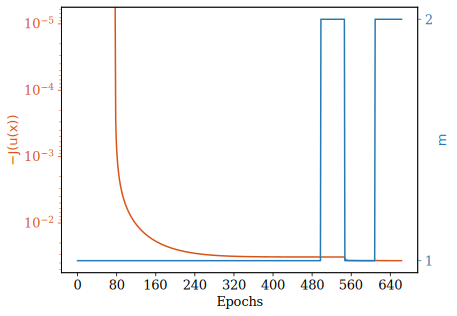

<Figure size 640x480 with 0 Axes>

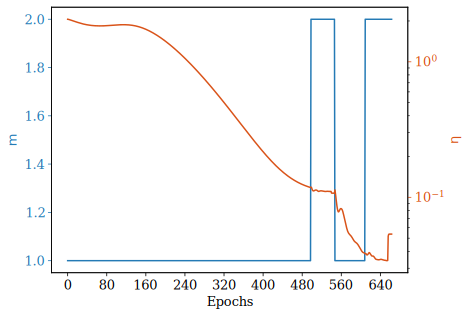

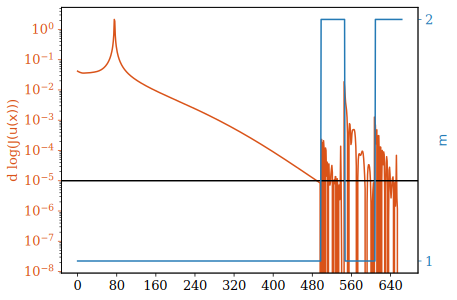

<Figure size 640x480 with 0 Axes>

In [30]:
tikz = False

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
plt.rcParams['text.usetex'] = False

Modes_flag = ROM_model.training_recap["Mode_vect"]
loss_training = ROM_model.training_recap["Loss_vect"]
decay = ROM_model.training_recap["Loss_decrease_vect"]
threshold = config["training"]["loss_decrease_c"]
error = ROM_model.training_recap["L2_error"]
name = 'Fig12a'


# plot Fig 5a

fig = plt.figure()
ax = fig.add_subplot(111)

## First curve
ax.invert_yaxis()
g1 = ax.semilogy(-torch.tensor(loss_training), color='#d95319ff')
ax.set_ylabel(r'$ - J\left(u\left(x\right)\right)$',color='#d95319ff')
ax.tick_params(axis='y', colors='#d95319ff', which='both')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel(r'Epochs')

## Second curve
ax2 = ax.twinx()
g2 = ax2.plot(Modes_flag, color='#247ab5ff')
ax2.set_ylabel(r'$m$',color='#247ab5ff')
ax2.tick_params(axis='y', colors='#247ab5ff')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

if tikz:
    import tikzplotlib
    tikzplotlib.save('Results/'+name+'_zoom.tex')
plt.savefig('Results/'+name+'_zoom.pdf', transparent=True, bbox_inches = "tight")

plt.show() 
plt.clf() 





name = 'Fig12b'

fig = plt.figure()
ax = fig.add_subplot(111)
g1 = ax.plot(Modes_flag, color='#247ab5ff')
ax.tick_params(axis='y', colors='#247ab5ff')
plt.ylabel(r'$m$',color='#247ab5ff')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Epochs')
ax2 = ax.twinx()

g2 = ax2.semilogy(torch.tensor(error), color='#d95319ff')
ax2.set_ylabel(r'$\eta$',color='#d95319ff')

ax2.tick_params(axis='y', colors='#d95319ff')

lns = g1+g2
labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc="upper center")
if tikz:
    import tikzplotlib
    tikzplotlib.save('Results/'+name+'.tex')
plt.savefig('Results/'+name+'.pdf', transparent=True, bbox_inches = "tight")

plt.show() 

plt.clf() 


name = 'Fig12c'

# plot Fig 15c

ax = plt.gca()
ax.semilogy(decay,color='#d95319ff')
ax.tick_params(axis='y', colors='#d95319ff')
ax.set_ylabel(r'd log($J\left(u\left(x\right)\right)$)',color='#d95319ff')
plt.axhline(threshold,color = 'k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


# plt.ylim((0.01,20))
ax2 = plt.gca().twinx()
ax2.plot(Modes_flag,color='#247ab5ff')
ax2.set_ylabel(r'$m$',color='#247ab5ff')
ax2.tick_params(axis='y', colors='#247ab5ff')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

if tikz:
    import tikzplotlib
    tikzplotlib.save('Results/'+name+'.tex')
plt.savefig('Results/'+name+'.pdf', transparent=True, bbox_inches = "tight")
plt.show() 

plt.clf()